# CSI 6160 Homework 1
### Samantha Bracellari & Justin Kur

For this assignment, we chose to implement the perceptron algorithm and train it on Sci-Kit Learn's breast cancer dataset.

The breast cancer dataset is an appropriate fit for the perceptron machine learning algorithm since it is a binary classification dataset. It has 569 samples, each with 30 attributes. This is known to be a relatively simple dataset, but we wanted to pick a dataset that the original perceptron implementation would perform well on and save the more complex datasets for more complex algorithms.

We first begin by importing any necessary packages & loading the data.

In [1]:
# imports
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt

In [2]:
data = load_breast_cancer()
X, Y = data['data'], data['target']

## Naive Guess Accuracy

For a binary classification task, the most natural evaluation metric is accuracy; however, if the dataset is highly unbalanced then even guessing the mode may give what appears to be a high accuracy score. As a simple check, we will first check how many instances of each class there are.

In [3]:
sz = len(Y) 
ones = Y.sum() # This works because the labels are 0 and 1
zeros = sz - ones
print(f"Number of instances labeled 0: {zeros}")
print(f"Number of instances labeled 1: {ones}")
naive_guess_rate = 100.0 * max(zeros, ones) / sz
print(f"Accuracy from guessing the mode: {naive_guess_rate:.1f}%")

Number of instances labeled 0: 212
Number of instances labeled 1: 357
Accuracy from guessing the mode: 62.7%


## The Perceptron Algorithm

Before implementing our own Perceptron algorithm, we wanted to establish a baseline using Sci-Kit Learn's Perceptron model. This would give us something to compare to when analyzing the accuracy of our own model. Sklearn's model yielded an accuracy score of roughly 93%; this gave us a number to try and reach with our model. We can also see that this is significantly higher than the naive guess accuracy, indicating that the perceptron is performing well on this dataset.

Considering the simplicity of both the algorithm and the dataset, we do not perform a train-test split. Although commonly used to prevent overfitting, with our small number of parameters overfitting should not be a large concern.

#### Sci-Kit's Perceptron

In [4]:
perceptron = Perceptron().fit(X, Y)
print(f"Train Accuracy: {100 * perceptron.score(X, Y):.1f}%")

Train Accuracy: 92.6%


#### Our Vanilla Perceptron

In [5]:
# perceptron algorithm implementation

def shuffle(a, b, rng: np.random.Generator):
    assert len(a) == len(b)
    p = rng.permutation(len(a))
    # Shuffles the array with numpy indexing
    return a[p], b[p]

def epoch_accuracy(X, Y, weights):
    num_correct = 0
    for x, y in zip(X, Y):
        # if using the bias term, append a 1 to the sample to account for the dimension change
        if weights.size != x.size:
            x = np.append(x, np.ones(1, dtype=np.float32))
        pred = int(x.dot(weights) >= 0.0) # 1 = positive, 0 = negative

        if pred == y:
            num_correct += 1

    return 100.0 * num_correct / len(X)

def train_loop(X, Y, num_epoch=100, use_bias=True, use_shuffle=False):
    train_scores = [] # for plotting purposes
    val_scores = []
    rng = np.random.default_rng(seed=0xDEADBEEF)
    # if we are using the bias term, we need to add an extra dimension to the weight vector
    # start with initial weights of 0
    weights = np.zeros(X.shape[1] + (1 if use_bias else 0)) 

    for epoch in range(num_epoch):
        if use_shuffle:
            X, Y = shuffle(X, Y, rng)
        num_correct = 0
        for x, y in zip(X, Y):
            # if using the bias term, append a 1 to the sample to account for the dimension change
            x = np.append(x, np.ones(1, dtype=np.float32)) if use_bias else x
            pred = int(x.dot(weights) >= 0.0) # 1 = positive, 0 = negative

            if pred != y: # misprediction
                if y == 1: # mistake on a positive
                    weights += x 
                else: # mistake on a negative
                    weights -= x
            else:
                num_correct += 1

        train_scores.append(100 * num_correct / len(X))
        val_scores.append(epoch_accuracy(X, Y, weights))
        if epoch % 10 == 0:
            print(f"Train Accuracy: {train_scores[-1]:.1f}%")
    return weights, train_scores, val_scores

weights, scores, val_scores = train_loop(data["data"], data["target"])

Train Accuracy: 70.5%
Train Accuracy: 85.6%
Train Accuracy: 88.6%
Train Accuracy: 87.9%
Train Accuracy: 88.4%
Train Accuracy: 89.1%
Train Accuracy: 89.3%
Train Accuracy: 89.5%
Train Accuracy: 91.4%
Train Accuracy: 90.0%


We ran our model for 100 iterations and spot checked the accuracy to ensure the model was behaving as expected. From the above output, you can see that the online training accuracy of our model hovered between 90-92%, which is pretty close to the accuracy score of Sci-Kit's built-in Perceptron algorithm. A graph below that depicts accuracy over time confirms this. However, if we take the run the computed weights across the entire dataset and check the accuracy we find the performance is worse than expected.

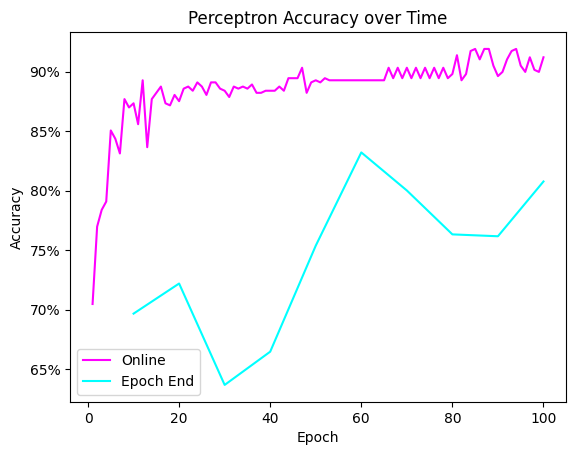

In [6]:
from matplotlib.ticker import FormatStrFormatter

def plot_loss(scores, val_scores, title):
    f, ax = plt.subplots()

    ax.plot(range(1, 101), scores, c='magenta', label="Online")
    # Average the epoch end accuracy results to smooth the curve
    epoch_end = [np.array(val_scores[x*10:(x+1)*10]) for x in range(10)]
    epoch_end = [x.mean() for x in epoch_end]
    ax.plot(range(10, 110, 10), epoch_end, c="cyan", label="Epoch End")
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend()
    fmt = '%.0f%%'
    ax.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    plt.show()

plot_loss(scores, val_scores, 'Perceptron Accuracy over Time')

We mitigate the above issue by shuffling the training examples at the beginning of each epoch. The online training accuracy decreases by a small amount, but the epoch end accuracy improves. In some sense, the perceptron was overly conditioned on the order of the training examples. 

Train Accuracy: 68.7%
Train Accuracy: 85.1%
Train Accuracy: 87.5%
Train Accuracy: 85.2%
Train Accuracy: 88.0%
Train Accuracy: 87.3%
Train Accuracy: 89.5%
Train Accuracy: 87.3%
Train Accuracy: 87.5%
Train Accuracy: 87.9%


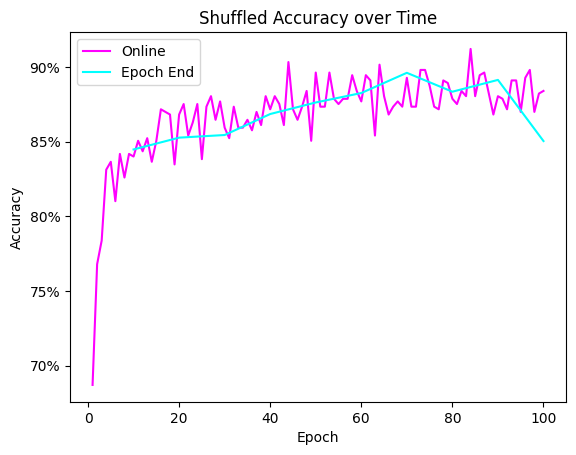

In [7]:
_, scores, val_scores = train_loop(data["data"], data["target"], use_shuffle=True)
plot_loss(scores, val_scores, 'Shuffled Accuracy over Time')

## Weights Visualization

As an extra experiment, we wanted to see how the model would perform if we were to perform singular value decomposition on it, reducing it from 30 features to 2. For this, we just used Sci-Kit Learn's `TruncatedSVD` function.

In [8]:
svd = TruncatedSVD()
small_X = svd.fit_transform(X) # reduce the dataset to 2 dimensions instead of 30

Then, we trained the model with the 2D data and checked the accuracy. Note that we're opting not to use the bias term here; this is solely for graphing purposes. This choice may lead to a reduction in the overall accuracy of the model, but it was still pretty good - around 79-80%.

In [9]:
small_weights, _, _ = train_loop(small_X, Y, use_bias=False)

Train Accuracy: 68.7%
Train Accuracy: 79.4%
Train Accuracy: 79.6%
Train Accuracy: 78.0%
Train Accuracy: 79.6%
Train Accuracy: 80.0%
Train Accuracy: 79.4%
Train Accuracy: 79.6%
Train Accuracy: 79.8%
Train Accuracy: 79.6%


In [10]:
rotated = np.zeros_like(small_weights) 
# Reconstruct the line from its normal vector
rotated[0] = small_weights[1]
rotated[1] = -1.0 * small_weights[0]
# Slope of the separating line
print(f"Slope of the separating line: {rotated[1] / rotated[0]}")

Slope of the separating line: -0.06439427808799958


Text(0.5, 1.0, 'Perceptron Separating Hyperplane in 2D')

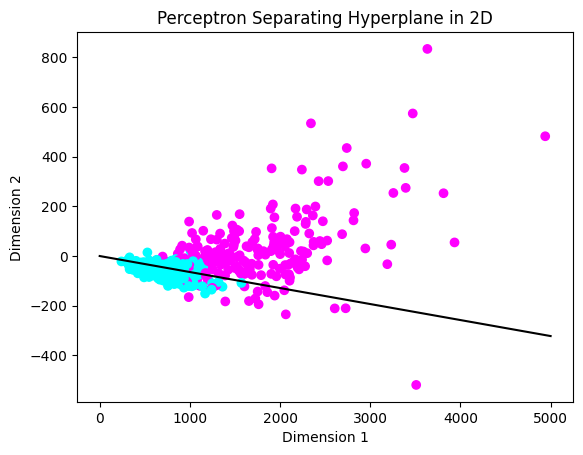

In [11]:
f, ax = plt.subplots()
colors = ['cyan' if y == 1 else 'magenta' for y in Y]
ax.scatter(small_X[:, 0], small_X[:, 1], c=colors)
line_x = np.linspace(0, 5000, 5)
line_y = line_x * (rotated[1] / rotated[0])
ax.plot(line_x, line_y, c='black')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title("Perceptron Separating Hyperplane in 2D")

We can see that even when reduced to 2 dimensions the two classes are quite separable. Here, it seems, it would be even better to separate off the cyan class with a curve - perhaps an ellipse. But even with our linear separator the accuracy is quite good.